# Config

In [1]:
import pandas as pd
import geopandas as gpd 
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as mpatches

# Get data

In [2]:
raw_df = pd.read_csv("../data/inca_accessibilitat.csv")

# Preview the data
print(raw_df.columns)
raw_df.head()

Index(['Gis_ID', 'N_Gis', 'Gis_X', 'Gis_Y', 'Longitud_X_WGS84',
       'Latitud_Y_WGS84', 'Incidència', 'Data d'Alta', 'Data de Baixa',
       'Situació', 'Tipus tram/carrer', 'Codi Grafo', 'ID Element Inventari',
       'Barri', 'Districte', 'Carrer', 'Numero Postal', 'Ubicació',
       'Accesibilitat', 'Tipus', 'Quantitat', 'Mesura', 'ALP Central',
       'ALP Façana', 'Adossat a façana (<0.50m)', 'Llargada', 'Amplada',
       'Amplada Gual', 'Amplada Pas de Vianants', 'Tipus Pas de Vianants',
       'Alçada', 'Amidament', 'Mesura mínima', 'Pendent Longitudinal',
       'Pendent Transversal', 'Pendent', 'Grao / Desnivell',
       'Tipus Direccional', 'Tipus Botons', 'Falta Direccional',
       'Falta Botons', 'Detall_Altres', 'Profunditat',
       'Cas No Compleix Mesura Longit.', 'Cas No Compleix Mesura Transv.',
       'Senyalització Horitzontal', 'Senyalització Vertical',
       'Reserva Accesible'],
      dtype='object')


/tmp/ipykernel_105292/4009262560.py:1: DtypeWarning: Columns (8,12,22,24,35,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv("../data/inca_accessibilitat.csv")


,Gis_ID,N_Gis,Gis_X,Gis_Y,Longitud_X_WGS84,Latitud_Y_WGS84,Incidència,Data d'Alta,Data de Baixa,Situació,...,Tipus Botons,Falta Direccional,Falta Botons,Detall_Altres,Profunditat,Cas No Compleix Mesura Longit.,Cas No Compleix Mesura Transv.,Senyalització Horitzontal,Senyalització Vertical,Reserva Accesible
0,53,1,428568.7713,4.578089e+06,2.146111,41.351130,CanviNivell,13/4/2018 0:00:00,NaN,Tram,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,54,2,428561.4783,4.578085e+06,2.146025,41.351097,Guals,13/4/2018 0:00:00,NaN,Cruïlla,...,NaN,NaN,NaN,NaN,120.0,NaN,NaN,NaN,NaN,NaN
2,55,3,428547.7503,4.578095e+06,2.145859,41.351181,AmpladaIlleta,13/4/2018 0:00:00,NaN,Cruïlla,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,75,4,431202.6671,4.582812e+06,2.177058,41.393901,Paviment,16/4/2018 0:00:00,NaN,Cruïlla,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,76,5,431179.3580,4.582835e+06,2.176776,41.394107,Paviment,16/4/2018 0:00:00,NaN,Cruïlla,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Process data
1. Filter the necessary rows.
2. Create new attributes
3. Make geodataframe
4. Evaluate
5. Keep needed rows

In [3]:
#Filter needed rows by 'Incidència'
df = raw_df[raw_df['Incidència'].isin(['Pendents', 'AmpladaLliure'])].copy()
print("Shape before filtering: ",raw_df.shape, "Shape after filtering: ", df.shape)

#Create new attributes
df = df.rename(columns={"Incidència": "Type",'Longitud_X_WGS84':"lon",'Latitud_Y_WGS84':"lat"})
df[["Value", "Evaluation","Description"]] = ["","",""] 

#Make geodataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Gis_X'], df['Gis_Y']),crs="EPSG:25831")

Shape before filtering:  (173144, 48) Shape after filtering:  (41647, 48)


## Evaluate by tresholds
I want an attribute with the value, and another with the evaluation

In [4]:
#Select specific rows
slope = gdf[gdf['Type'] == 'Pendents'].copy()
slope.dropna(subset=['Pendent Longitudinal','Pendent Transversal'], inplace=True)  # Ensure 'Pendents' is not NaN

# Assign columns using .loc to avoid warningsº
slope.loc[:, "Value"] = slope.apply(
    lambda row: f"Longitudinal {row['Pendent Longitudinal']}, Transversal {row['Pendent Transversal']}",
    axis=1
)

# Define evaluation logic row-wise
def evaluate(row):
    if row['Pendent Longitudinal'] == "<= 6%" and row['Pendent Transversal'] == "<= 2%":
        return "Accessible"
    elif row['Pendent Longitudinal'] == "<= 6%" and row['Pendent Transversal'] != "<= 2%":
            return "Accessible Transversally"
    elif row['Pendent Longitudinal'] != "<= 6%" and row['Pendent Transversal'] == "<= 2%":
            return "Accessible Longitudinally"
    else:
        return "Non accessible"

slope.loc[:, "Evaluation"] = slope.apply(evaluate, axis=1)

slope.loc[:, "Description"] = "Longitudinal and transversal unevenness of the sidewalk"

#Translate
slope = slope.replace({"Type": {"Pendents": "Slope"}})

slope[["Value","Type", "Evaluation", "Description"]].head()

,Value,Type,Evaluation,Description
21,"Longitudinal <= 6%, Transversal <= 2%",Slope,Accessible,Longitudinal and transversal unevenness of the...
59,"Longitudinal <= 6%, Transversal <= 2%",Slope,Accessible,Longitudinal and transversal unevenness of the...
99,"Longitudinal <= 6%, Transversal <= 2%",Slope,Accessible,Longitudinal and transversal unevenness of the...
141,"Longitudinal <= 6%, Transversal <= 2%",Slope,Accessible,Longitudinal and transversal unevenness of the...
181,"Longitudinal <= 6%, Transversal <= 2%",Slope,Accessible,Longitudinal and transversal unevenness of the...


In [5]:
#Select specific rows
width = gdf[gdf['Type'] == 'AmpladaLliure'].copy()
width.dropna(subset=["Mesura"], inplace=True)  # Ensure 'Mesura' is not NaN

# Fix large values with .loc
width.loc[width["Mesura"] >= 10000, "Mesura"] = width.loc[width["Mesura"] >= 10000, "Mesura"] / 100

# Assign columns using .loc to avoid warnings
width.loc[:, "Value"] = width["Mesura"]
width.loc[:, "Evaluation"] = width["Mesura"].apply(lambda x: "Accessible" if x >= 180 else "Partially accessible")
width.loc[:, "Description"] = "Width available for pedestrians or other sidewalk users"

#Translate
width = width.replace({"Type": {"AmpladaLliure": "Width"}})

width[["Value","Type", "Evaluation", "Description"]].head()

,Value,Type,Evaluation,Description
17,370.0,Width,Accessible,Width available for pedestrians or other sidew...
19,320.0,Width,Accessible,Width available for pedestrians or other sidew...
22,180.0,Width,Accessible,Width available for pedestrians or other sidew...
23,370.0,Width,Accessible,Width available for pedestrians or other sidew...
24,380.0,Width,Accessible,Width available for pedestrians or other sidew...


## Results layer

In [6]:
results = pd.concat([slope, width], ignore_index=True)
results = results[["Gis_ID","Type","Value", "Evaluation", "Description", "geometry", "lat","lon"]]
results["Value"] = results["Value"].astype(str)
results.sort_values(by="Gis_ID").head()

,Gis_ID,Type,Value,Evaluation,Description,geometry,lat,lon
20483,98,Width,370.0,Accessible,Width available for pedestrians or other sidew...,POINT (431235.986 4582859.732),41.394333,2.177451
20484,100,Width,320.0,Accessible,Width available for pedestrians or other sidew...,POINT (431225.07 4582869.885),41.394424,2.177319
0,103,Slope,"Longitudinal <= 6%, Transversal <= 2%",Accessible,Longitudinal and transversal unevenness of the...,POINT (431227.311 4582869.933),41.394424,2.177346
20485,105,Width,180.0,Accessible,Width available for pedestrians or other sidew...,POINT (428635.088 4578118.05),41.351400,2.146901
20486,106,Width,370.0,Accessible,Width available for pedestrians or other sidew...,POINT (431264.038 4582934.616),41.395010,2.177778


In [7]:
mapping = {
    "Accessible": 1,
    "Partially accessible": 0.5,
    "Accessible Transversally": 0.5,
    "Accessible Longitudinally": 0.5,
    "Non accessible": 0,}
results.loc[:, "Score"] = results["Evaluation"].map(mapping)
results["Score"].describe()

count    40137.000000
mean         0.847011
std          0.262581
min          0.000000
25%          0.500000
50%          1.000000
75%          1.000000
max          1.000000
Name: Score, dtype: float64

In [8]:
mapping = {
    "Accessible": 1,
    "Partially accessible": 0.5,
    "Accessible Transversally": 0.5,
    "Accessible Longitudinally": 0.5,
    "Non accessible": 0,}
results.loc[:, "Score"] = results["Evaluation"].map(mapping)
results["Score"].describe()

count    40137.000000
mean         0.847011
std          0.262581
min          0.000000
25%          0.500000
50%          1.000000
75%          1.000000
max          1.000000
Name: Score, dtype: float64

# Metrics

In [9]:
results["Value"].value_counts(dropna=False)

Value
Longitudinal <= 6%, Transversal <= 2%    13930
Longitudinal > 6%, Transversal <= 2%      3584
Longitudinal <= 6%, Transversal > 2%      1696
360.0                                     1453
Longitudinal > 6%, Transversal > 2%       1273
                                         ...  
474.0                                        1
1070.0                                       1
985.0                                        1
2027.0                                       1
1130.0                                       1
Name: count, Length: 793, dtype: int64

In [10]:
results["Evaluation"].value_counts(dropna=False)

Evaluation
Accessible                   29129
Partially accessible          4455
Accessible Longitudinally     3584
Accessible Transversally      1696
Non accessible                1273
Name: count, dtype: int64

In [11]:
results["Type"].value_counts(dropna=False)

Type
Slope    20483
Width    19654
Name: count, dtype: int64

# Visualize data

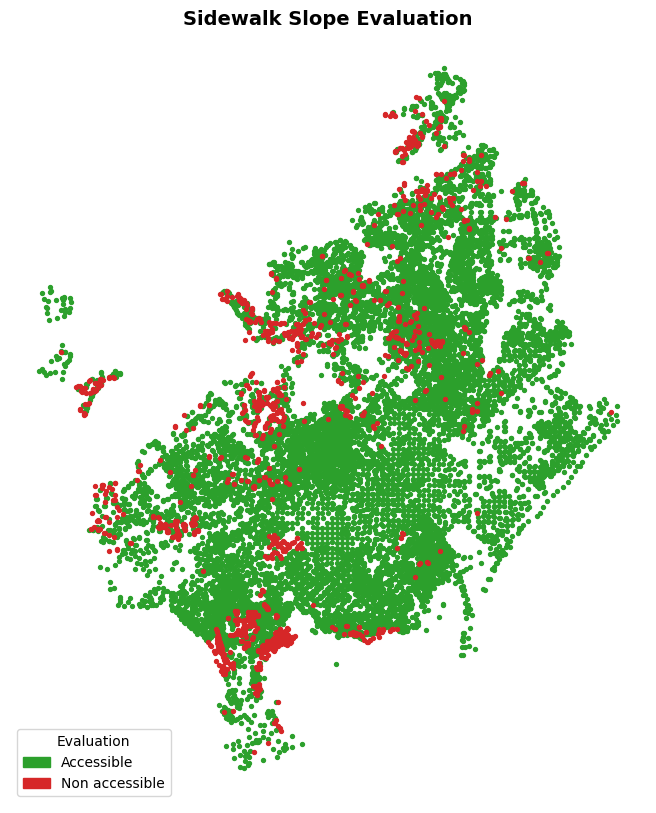

In [12]:


# Define colors for each category (adjust as you like)
category_colors = {
    "Accessible": "#2ca02c",               # green
    "Non accessible": "#d62728",                      # red
}

# Ensure 'Evaluation' is a categorical column
slope["Evaluation"] = slope["Evaluation"].astype("category")

# Create figure
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each category separately so we control the legend colors
for category, color in category_colors.items():
    slope[slope["Evaluation"] == category].plot(
        ax=ax,
        color=color,
        markersize=8,
        label=category
    )

# Legend
handles = [mpatches.Patch(color=color, label=label) 
           for label, color in category_colors.items()]
ax.legend(handles=handles, title="Evaluation", loc="lower left")

# Remove axes
ax.set_axis_off()
ax.set_title("Sidewalk Slope Evaluation", fontsize=14, fontweight="bold")

plt.show()


<Axes: >

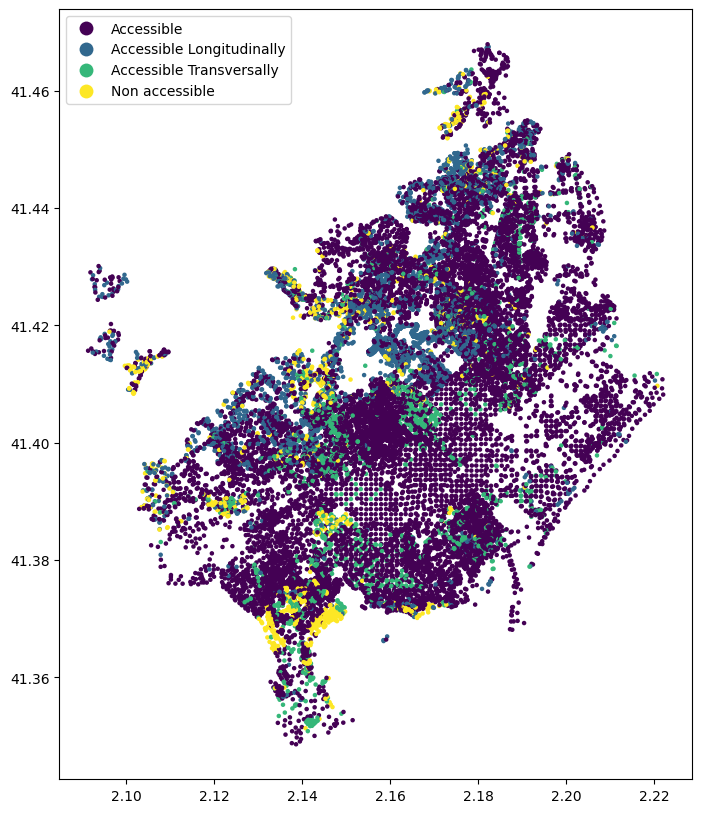

In [13]:
slope.to_crs(epsg=4326, inplace=True)  # Convert to WGS84 for GeoJSON compatibility
slope.plot(
    column='Evaluation',
    legend=True,
    figsize=(10, 10),
    markersize=5,
    cmap='viridis'
)

<Axes: >

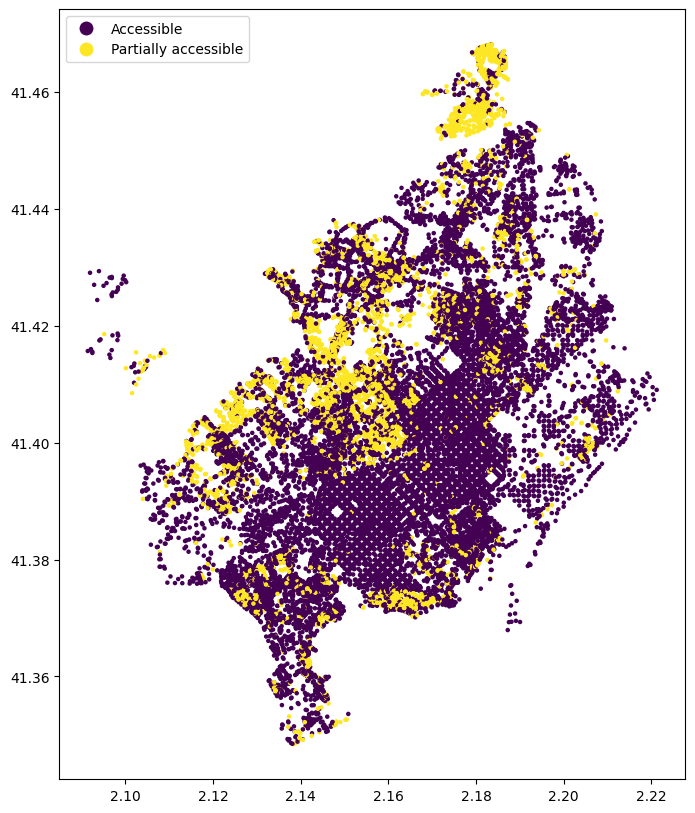

In [14]:
width.to_crs(epsg=4326, inplace=True)  # Convert to WGS84 for GeoJSON compatibility
width.plot(
    column='Evaluation',
    legend=True,
    figsize=(10, 10),
    markersize=5,
    cmap='viridis'
)

# Save data


In [15]:
for dataset in [slope,  width]:
    dataset.to_crs(epsg=4326, inplace=True)  # Convert to WGS84 for GeoJSON compatibility
    dataset[["Gis_ID","Type","Value", "Evaluation", "Description", "geometry", "lat","lon"]].to_file(
        f"../data/IMPD_{dataset['Type'].iloc[0].lower()}.geojson", driver='GeoJSON', index=False)
results.to_crs(epsg=4326, inplace=True)  # Convert to WGS84 for GeoJSON compatibility
results.to_file(
    f"../data/IMPD_all.geojson", driver='GeoJSON', index=False)

I